In [188]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil
from functools import reduce
import hashlib
import uuid

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

In [3]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [20]:
# ds

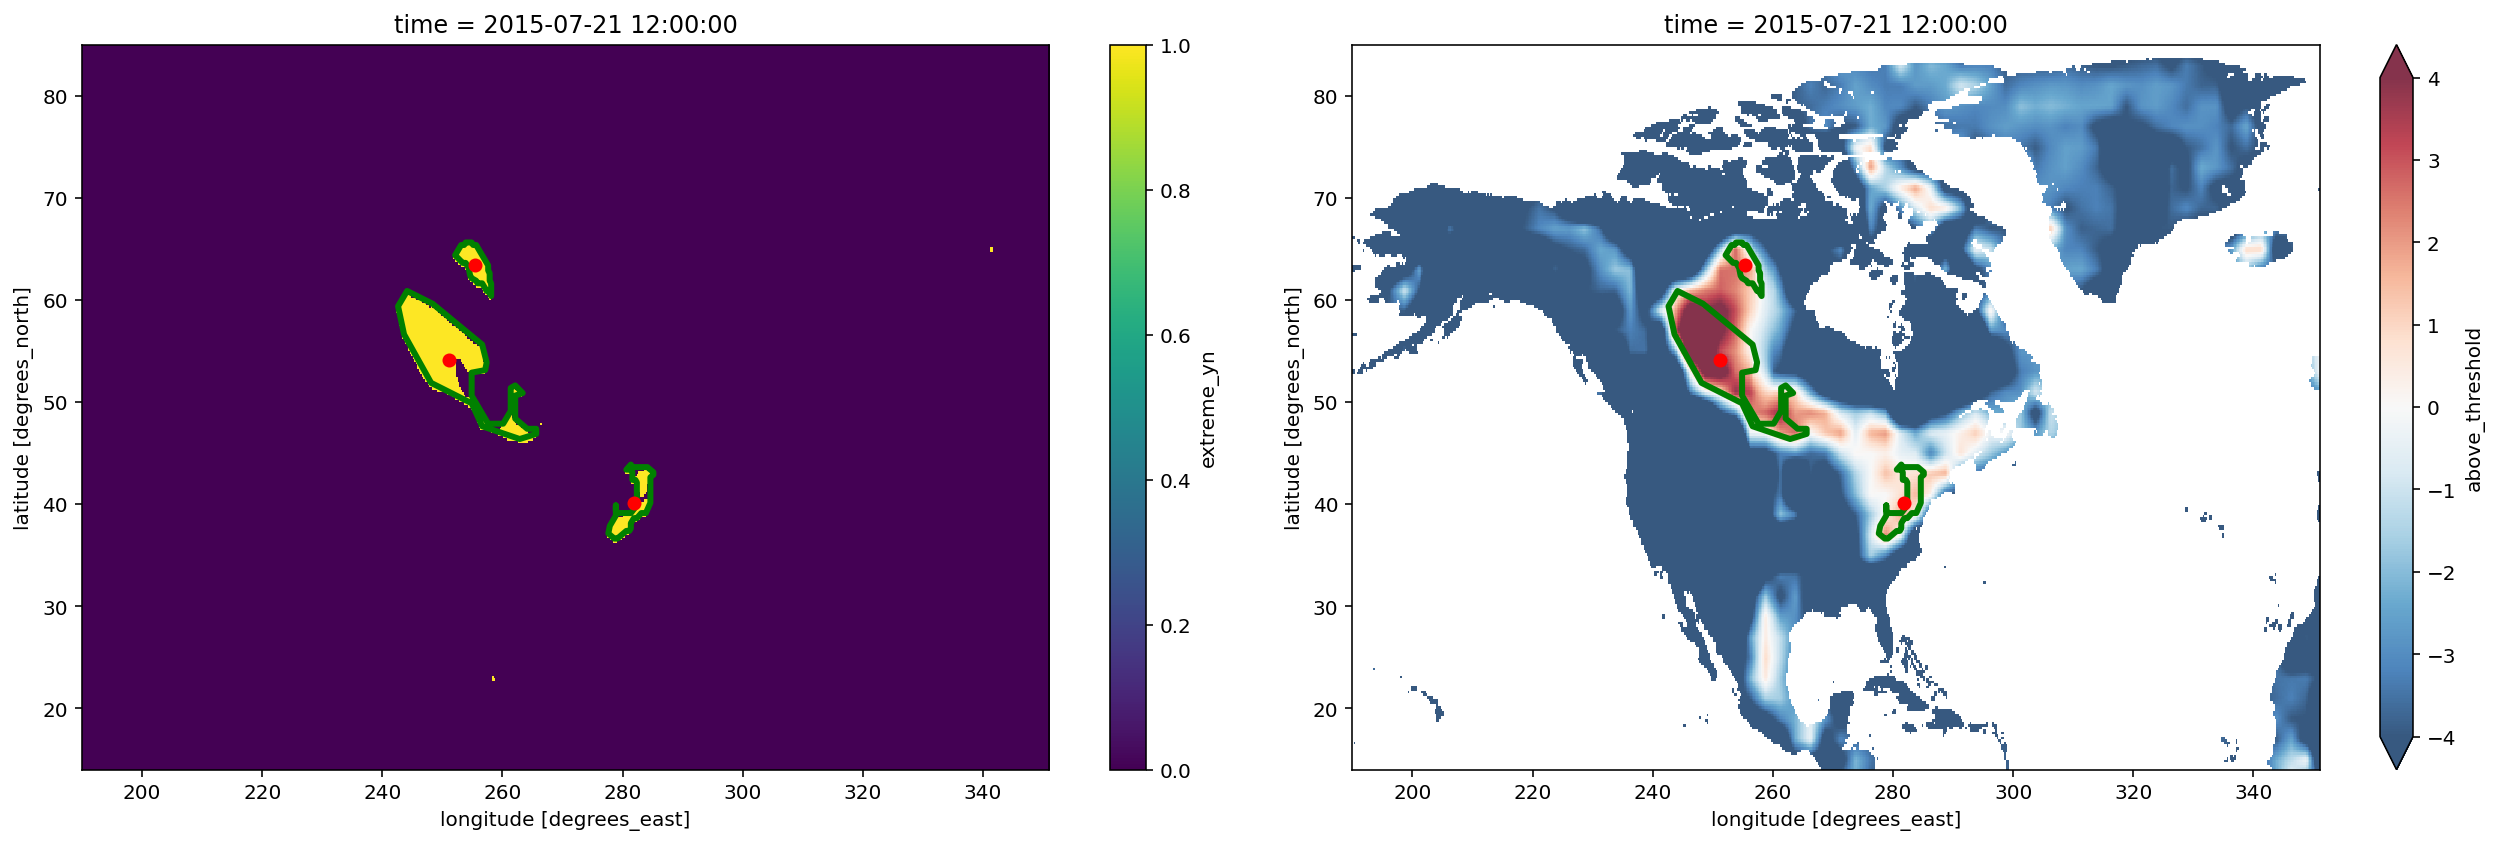

In [205]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

# constants for openCV countour finding
SMOOTH_RATIO = 0.005
AREA_TRESH = 50

# constants derived from the root dataset
IMG_SHAPE = (ds.dims['lat'], ds.dims['lon'])
LONS = ds.coords['lon']
LATS = ds.coords['lat']


class Contour():
    """A single contour obj. All unit operations are managed here."""
    
    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.name = uuid.uuid4().hex[:6]
        self._area = 0.0
        self._smoothened = np.array([], dtype=np.int32)
        self._projected = np.array([], dtype=np.float64)
        self._center = ()
    
    def __repr__(self):
        return self.name
    
    @property
    def area(self):
        return cv2.contourArea(self.contour)
    
    @property
    def smoothened(self):
        cnt = self.contour
        arc = SMOOTH_RATIO*cv2.arcLength(cnt,True)
        return cv2.approxPolyDP(cnt,arc,True)
    
    @property
    def projected(self):
        squeezed = self.smoothened.squeeze()
        proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in squeezed]
        return np.array(proj).reshape((-1,1,2))
    
    @property
    def center(self):
        M = cv2.moments(self.contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (float(LONS[cX]), float(LATS[cY])) 
        
    def overlaps(self, obj2:object) -> bool:
        """Check if two contour objects overlap."""
        ctrs = [self.contour, obj2.contour]
        zeros = np.zeros(IMG_SHAPE)
        img1 = cv2.drawContours(zeros.copy(), ctrs, 0, 1)
        img2 = cv2.drawContours(zeros.copy(), ctrs, 1, 1)
        intersection = np.logical_and(img1, img2)
        return intersection.any()
    
    def __add__(self, obj2):
        """Fuse two countor objects, if they overlap."""
        if self.overlaps(obj2):
            c1, c2 = self.contour, obj2.contour
            fused = cv2.convexHull(np.vstack([c1, c2]))
            larger = [self, obj2][np.argmax([self.area, obj2.area])]
            larger.contour = fused
#             self.contour = fused
            return (larger,)
        else:
            return (self, obj2)

def find_contours(arr2d: np.array, 
                  extend:bool=False, 
                  min_area:int=50) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),].
    input:  day-slice of a dataset tasmax dataarray
    output: list of contours (np.arrays)"""
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if extend:
        contours = [cv2.convexHull(c) for c in contours]
        
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    contours = [Contour(c) for c in contours]
    contours = [c for c in contours if c.area>min_area]
    
    return contours

####################################
# Visualize a random day
####################################

# select the day to plot
idx = 201

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, extend=False, min_area=150) 

# add these patches on the plot(s)
patches = [Polygon(c.projected.squeeze(), True) for c in contours]

args = dict(edgecolors=("g",), linewidths=(3,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
[ax1.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]
p = PatchCollection(patches, **args)
ax2.add_collection(p)
[ax2.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]

fig.tight_layout()


In [208]:
####################################
# Loop through days
####################################

def collapse(contours:List[Contour]) -> List[Contour]:
    contours = contours[:] # prevent mutation
    for cnt1, cnt2 in itertools.combinations(contours, 2):
        if cnt1.overlaps(cnt2):
            cnt_new = cnt1+cnt2
            if len(cnt_new)==1:
                print('fused:  ', cnt1, '+', cnt2, '->', cnt_new[0])
                contours.remove(cnt1)
                contours.remove(cnt2)
                contours.append(cnt_new[0])
            return collapse(contours) # recursion
    return contours

contours = []
days = []
for idx in range(195,205):

    dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
    day = dr[idx].strftime("%Y-%m-%d")
    tasmax = ds['tasmax'].sel(time=day)
    tdiff = ds['above_threshold'].sel(time=day)
    extreme = ds['extreme_yn'].sel(time=day)

    arr2d = extreme.values[0]
    
    cnts = find_contours(arr2d, extend=False, min_area=150)
    print(cnts)
    contours += cnts
    days += [day]

# df_contours = pd.DataFrame(dict(days=days, contours=contours))
# df_contours

collapse(contours)

[d746d0]
[bd0887]
[603eb8]
[7cb270]
[611525, 36c055]
[ff52c8]
[80c403, 38b49f, 3f05aa]
[8b55a9, 000482, 9761e3]
[4ac5ee, a79626]
[2b5494, 81473c, 336a48]
fused:   d746d0 + bd0887 -> bd0887
fused:   603eb8 + 7cb270 -> 603eb8
fused:   611525 + bd0887 -> bd0887
fused:   36c055 + ff52c8 -> 36c055
fused:   80c403 + 8b55a9 -> 8b55a9
fused:   38b49f + 000482 -> 38b49f
fused:   3f05aa + 9761e3 -> 9761e3
fused:   4ac5ee + 2b5494 -> 2b5494
fused:   a79626 + 336a48 -> a79626
fused:   81473c + 36c055 -> 36c055
fused:   603eb8 + bd0887 -> 603eb8
fused:   8b55a9 + 2b5494 -> 2b5494
fused:   38b49f + 36c055 -> 36c055
fused:   9761e3 + a79626 -> 9761e3
fused:   603eb8 + 36c055 -> 603eb8


[2b5494, 9761e3, 603eb8]

1